## feature 1 : face mesh - swap

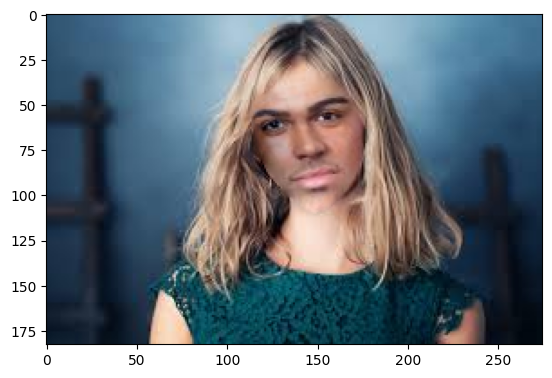

In [17]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import math

# Load face mesh model
mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)

# mpDraw.draw_landmarks() 함수 일부 문장 복사
def normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) :
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

# face landmarks detection and get points
def getPoints(img,cvt_color=None,return_cvt_img=True):
    img_rows,img_cols = img.shape[:2]
    if cvt_color:
        img = cv2.cvtColor(img,cvt_color)
    else:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
         
    result = faceMesh.process(img) # one landmarks of faces 
    
    # landmarks x,y pair
    points = []
    for landmark in result.multi_face_landmarks[0].landmark: # normalized x,y,z points
        points.append(normalized_to_pixel_coordinates(landmark.x,landmark.y,img_cols,img_rows))
        # print(landmark.x,landmark.y)

    if return_cvt_img:
        return points, img
    else:
        return points

# Delaunay triangulation
def getTriangles(img,points):
    h,w = img.shape[:2]
    subdiv = cv2.Subdiv2D((0,0,w,h));
    subdiv.insert(points)
    triangleList = subdiv.getTriangleList()
    triangles = []
    for t in triangleList:
        pt = t.reshape(-1,2)
        if not (pt < 0).sum() and not (pt[:,0] > h).sum() \
                              and not (pt[:,1] > w).sum():
            indice = []
            for i in range(0,3):
                for j in range(0,len(points)):
                    if abs(pt[i][0]-points[j][0]) < 1.0 \
                        and abs(pt[i][1]-points[j][1]) < 1.0:
                        indice.append(j)
            if len(indice) == 3:
                triangles.append(indice)
    
    return triangles

# affine
def warpTriangle(img1,img2,pts1,pts2):
    x1,y1,w1,h1 = cv2.boundingRect(np.float32([pts1])) # x,y : left-top points / w,h : length
    x2,y2,w2,h2 = cv2.boundingRect(np.float32([pts2]))

    roi1 = img1[y1:y1+h1, x1:x1+w1]
    roi2 = img2[y2:y2+h2, x2:x2+w2]
    
    offset1 = np.zeros((3,2),dtype=np.float32)
    offset2 = np.zeros((3,2),dtype=np.float32)
    for i in range(3):
        offset1[i][0], offset1[i][1] = pts1[i][0]-x1,pts1[i][1]-y1
        offset2[i][0], offset2[i][1] = pts2[i][0]-x2,pts2[i][1]-y2

    mtrx = cv2.getAffineTransform(offset1,offset2)
    
    warped = cv2.warpAffine(roi1,mtrx,(w2,h2),None,cv2.INTER_LINEAR,cv2.BORDER_REFLECT101)
    mask = np.zeros((h2,w2),dtype=np.uint8)
    cv2.fillConvexPoly(mask,np.int32(offset2),(255))
    
    warped_masked = cv2.bitwise_and(warped,warped,mask=mask)
    roi2_masked = cv2.bitwise_and(roi2,roi2,mask=cv2.bitwise_not(mask))
    roi2_masked = roi2_masked + warped_masked
    
    img2[y2:y2+h2, x2:x2+w2] = roi2_masked

# main 
# 1. 이미지 로드
img2 = cv2.imread("images.jpg")
img1 = cv2.imread("images2.jfif")

# 2. landmarks detection
points1, img1 = getPoints(img1)
points2, img2 = getPoints(img2)

img_draw = img2.copy()

# 3. 볼록 선체(convex hull) 구하기 
hullInedx = cv2.convexHull(np.array(points2),returnPoints=False)
hull1 = [points1[int(idx)] for idx in hullInedx]
hull2 = [points2[int(idx)] for idx in hullInedx]

# 4. 볼록 선체 안 들로네 삼각형 좌표 구하기
triangles = getTriangles(img2,hull2)

# 5. 각 삼각형 좌표로 어핀 변환
for i in range(0,len(triangles)):
    t1 = [hull1[triangles[i][j]] for j in range(3)]
    t2 = [hull2[triangles[i][j]] for j in range(3)]
    warpTriangle(img1,img_draw,t1,t2)
    
# 6. 볼록 선체를 마스크로 써서 얼굴 합성
mask = np.zeros(img2.shape[:2],dtype=img2.dtype)
cv2.fillConvexPoly(mask,np.int32(hull2),(255,255,255))
r = cv2.boundingRect(np.float32(hull2))
center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
output = cv2.seamlessClone(np.uint8(img_draw),img2,mask,center,cv2.NORMAL_CLONE)

plt.imshow(output)
plt.show()

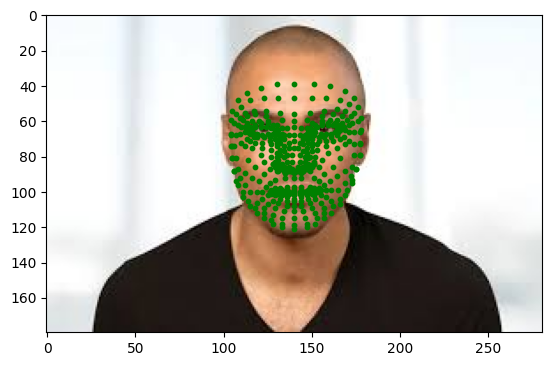

In [18]:
a,img1 = getPoints(img1.copy())
a = np.array(a)
plt.scatter(a[:,0],a[:,1],s=10,c='green')
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

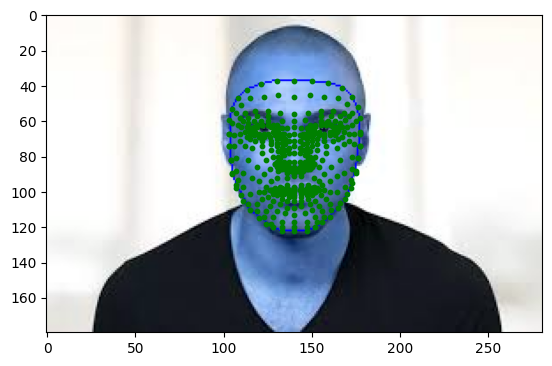

In [19]:
# landmarks
a,img1 = getPoints(img1.copy())
# convex hull
a = np.array(a)
hull1 = np.array(hull1)
cv2.drawContours(img1,[hull1],0,(255,0,0),1)
plt.scatter(a[:,0],a[:,1],s=10,c='green')
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()

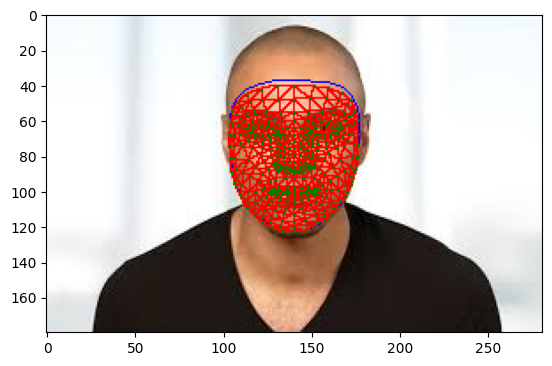

In [20]:
# landmarks
a,img1 = getPoints(img1.copy())
# convex hull
cv2.drawContours(img1,[hull1],0,(255,0,0),1)
# delaunay triangulation
h,w = img1.shape[:2]
subdiv = cv2.Subdiv2D((0,0,w,h))
subdiv.insert(a)
triangleList = subdiv.getTriangleList()

for t in triangleList:
    pts = t.reshape(-1,2).astype(np.int32)
    if (pts < 0).sum() or (pts[:,0]>w).sum() or (pts[:,1] > h).sum():
        continue
    cv2.polylines(img1,[pts],True,(0,0,255),1,cv2.LINE_4)


a = np.array(a)
hull1 = np.array(hull1)
plt.scatter(a[:,0],a[:,1],s=1,c='green')
plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
plt.show()



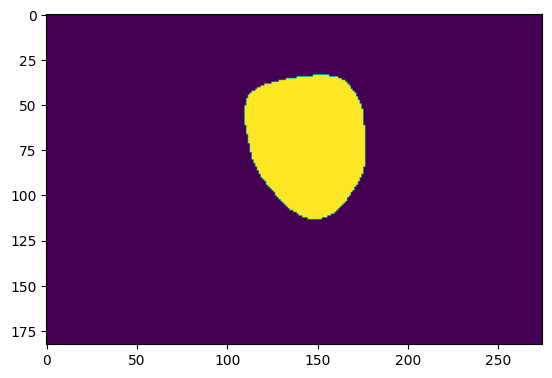

In [23]:
plt.imshow(mask)
plt.show()


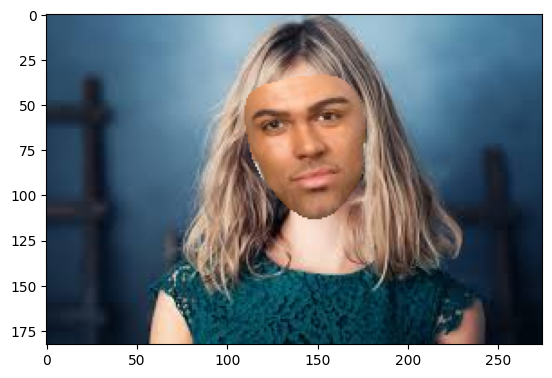

In [30]:
plt.imshow(np.uint8(img_draw))
plt.show()